## Goal : Compare Fst values in novel exonic regions compared to known

In [60]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot
import math


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [61]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [62]:
exon_parts = proc_cfg(config['lr']['exons_novel_part_fsts_summary'],od)
ref_exons = proc_cfg(config['ref']['exons_fsts_summary'],od)
exon_info = proc_cfg(config['lr']['exon_info'],od)

In [63]:
def read_fst_summ(f):
    # print(f)
    df = pd.read_csv(f,
                 sep='\t')

    # set all <0 fsts --> 0 https://www.biostars.org/p/132253/
    df.loc[df.fst<0, 'fst'] = 0

    # since this is biallelic snp level, remove all exons that didnt intersect
    n = len(df.index)
    df = df.loc[df.End_b!=-1]
    n2 = len(df.index)
    assert n != n2
    # print(n2)
    
    return df

In [73]:
nov_df = read_fst_summ(exon_parts)
known_df = read_fst_summ(ref_exons)
df = pd.read_csv(exon_info, sep='\t')

# limit annot. exons to the expressed ones
known_df = known_df.loc[known_df.eid.isin(df.eid.tolist())]
known_df['novelty'] = 'Known'

df = pd.concat([nov_df, known_df], axis=0)

In [72]:
# init_plot_settings()
# ax = sns.displot(df, 
#             x='fst',
#             kind='kde')
# plt.show()
# plt.clf()

# # plot the Fst dists. for pop-spec and non-pop-spec
# init_plot_settings()
# ax = sns.displot(df, 
#             x='fst',
#             kind='ecdf') 
# plt.show()
# plt.clf()

In [75]:
# limit only to contrasts that involve CEU
# because we know that the annotation, and therefore exon novelty
# is eur-biased
df = df.loc[(df.pop1=='CEU')|(df.pop2=='CEU')]
# print(df.pop1.unique())
# print(df.pop2.unique())

In [77]:
# for each combination of exon, get the std FST of SNPs in the 
# exon, across the contrasts
gb_cols = ['eid', 'novelty'] # exon id stuff
keep_cols = gb_cols+['fst']
temp = df[keep_cols].groupby(gb_cols).std().reset_index().rename({'fst':'std_fst'}, axis=1)

# make sure we have no dupe eid / var. pos. combos
assert len(temp.index) == len(temp[['eid']].drop_duplicates().index)

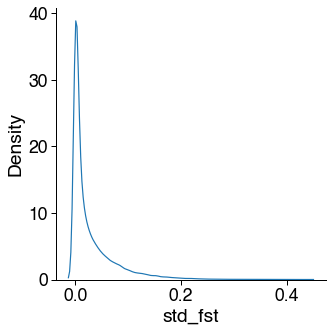

<Figure size 360x360 with 0 Axes>

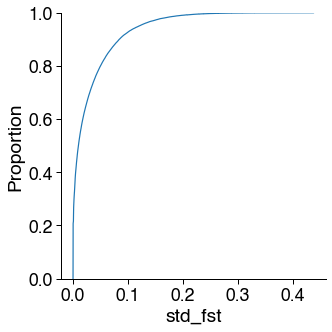

<Figure size 360x360 with 0 Axes>

In [78]:
init_plot_settings()
ax = sns.displot(temp, 
            x='std_fst',
            kind='kde')  
plt.show()
plt.clf()

# plot the Fst dists. for pop-spec and non-pop-spec
init_plot_settings()
ax = sns.displot(temp, 
            x='std_fst',
            kind='ecdf') 
plt.show()
plt.clf()

In [79]:
# for each novel exon, get mean fst across 
# 1. positions
# 2. separate pieces (duplicate w/ the prev.) and
# 3. fst contrasts


# for each combination of exon and variant position, get the mean FST
# (which will be the mean between the contrasts)
gb_cols = ['eid', 'novelty', # exon id stuff
           'End_b', 'Start_b'] # var. pos. stuff
keep_cols = gb_cols+['fst']
df = df[keep_cols].groupby(gb_cols).mean().reset_index().rename({'fst':'mean_fst'}, axis=1)

# make sure we have no dupe eid / var. pos. combos
assert len(df.index) == len(df[['eid', 'End_b', 'Start_b']].drop_duplicates().index)


In [80]:
# now also take the mean-mean fst across all variant positions for each exon
gb_cols = ['eid', 'novelty']
keep_cols = gb_cols+['mean_fst']
df = df[keep_cols].groupby(gb_cols).mean().reset_index().rename({'mean_fst':'mean_mean_fst'}, axis=1)

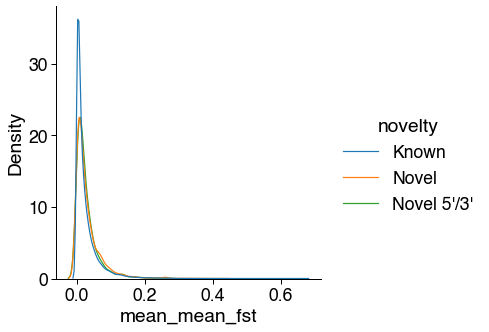

<Figure size 360x360 with 0 Axes>

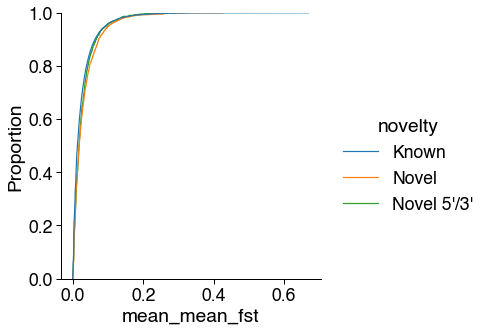

1043
Novel 5'/3' vs. Known:
54708610.5
1.4539257161123482e-09

2832
Novel vs. Known:
150055947.5
4.403349066745402e-27



<Figure size 360x360 with 0 Axes>

In [81]:
# plot the Fst dists. for pop-spec and non-pop-spec
init_plot_settings()
ax = sns.displot(df, 
            x='mean_mean_fst',
            hue='novelty',
            kind='kde',
            common_norm=False)  
plt.show()
plt.clf()

# plot the Fst dists. for pop-spec and non-pop-spec
init_plot_settings()
ax = sns.displot(df, 
            x='mean_mean_fst',
            hue='novelty',
            kind='ecdf') 
plt.show()
plt.clf()

for nov in ["Novel 5'/3'", 'Novel']:


    x = df.loc[df.novelty==nov,'mean_mean_fst'].tolist() # hyp. --> greater
    print(len(x))
    y = df.loc[df.novelty=='Known','mean_mean_fst'].tolist()

    # print(f'{pop1} vs {pop2}')
    # print(temp.loc[temp.thing2=='unique','fst'].median())
    # print(temp.loc[temp.thing2=='shared','fst'].median())
    # print()

    print(f'{nov} vs. Known:')
    stat, pval = st.mannwhitneyu(x, y, alternative='greater')
    print(stat)
    print(pval)
    print()

In [82]:
df.head()

,eid,novelty,mean_mean_fst
0,chr10_+_1000676_1000868,Known,0.012713
1,chr10_+_1000947_1001013,Known,0.006561
2,chr10_+_100231245_100231660,Known,0.016604
3,chr10_+_100233230_100233443,Known,0.026507
4,chr10_+_100266373_100266499,Known,0.014179


In [83]:
df.to_csv('250219_novel_exon_fsts.tsv', sep='\t', index=False)